### Train model on a loans dataset for identifying attributions of NN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time #check min_threshold values for cloud storage
from sklearn.model_selection import train_test_split #don't use for time-series baseline!
from sklearn.metrics import accuracy_score, confusion_matrix
from model import LoanNetwork

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv("../data/loans/train.csv")

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data pre-processing

In [4]:
### generate synthetic seed data.
def generate_data(n_observations, reference=None, factor=0, min=1, max=100):
#     factor *= np.random.normal(0, 1) #adding gaussian noise
    return np.random.randint(min, max, size=(n_observations)) if reference is None else np.array(reference) + factor

In [5]:
def preprocess_df(dataframe, isTest=False):
    """Preprocess a dataframe, unique to the loan_prediction dataset"""
    #perform deep copy, fixes self assignment bug:
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    df = dataframe.copy(deep=True)
    
    null_df = np.sum(df.isnull())
    print(null_df) 
    print(f"\nTotal null values: {np.sum(null_df)}") #get total number of null values
    ### remove all rows with null values
    df = df.dropna(how='any',axis=0) 
    del df['Loan_ID'] #remove Loan_ID (irrelevant)

    #based on attribution scores
#     del df["ApplicantIncome"]
    
    # convert to binary variables

    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #> ----Gender---
    ## - Male: 0
    ## - Female: 1
    df.loc[(df.Gender == 'Male'),'Gender']=0
    df.loc[(df.Gender == 'Female'),'Gender']=1

    #> ----Married---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Married == 'Yes'),'Married']=0
    df.loc[(df.Married == 'No'),'Married']=1

    #> ----Education---
    ## - Not Graduate: 0
    ## - Graduate: 1
    df.loc[(df.Education == 'Not Graduate'),'Education']=0
    df.loc[(df.Education == 'Graduate'),'Education']=1

    #> ----Self_Employed---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Self_Employed == 'No'),'Self_Employed']=0
    df.loc[(df.Self_Employed == 'Yes'),'Self_Employed']=1


    #> ----Property_area---
    ## - Rural: 0
    ## - Urban: 1
    ## - Semiurban: 2
    df.loc[(df.Property_Area == 'Rural'),'Property_Area']=0
    df.loc[(df.Property_Area == 'Urban'),'Property_Area']=1
    df.loc[(df.Property_Area == 'Semiurban'),'Property_Area']=2
    
    
    #> ----Loan_Status--- (ONLY for Training set)
    ## - No: 0
    ## - Yes: 1
    if(not isTest):
        df.loc[(df.Loan_Status == 'N'),'Loan_Status']=0
        df.loc[(df.Loan_Status == 'Y'),'Loan_Status']=1

    #> -----Dependents-----
    #set max as 
    df.loc[(df.Dependents == '3+'), 'Dependents'] = 3
    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------
    
    ### perform synthetic mutations
    m, n = df.shape
#     df.insert(0, 'synthetic0', generate_data(m, reference=df.Loan_Status))
#     df.insert(n, 'synthetic1', generate_data(m, reference=df.Loan_Status, factor=1))
    
    #!!! Typecase to float (for tensors below)
    df = df.astype(float)
    
    return df

In [6]:
df = preprocess_df(df)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Total null values: 149


In [7]:
df.head() #processed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0.0,0.0,1.0,1.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,2583.0,2358.0,120.0,360.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,6000.0,0.0,141.0,360.0,1.0,1.0,1.0
5,0.0,0.0,2.0,1.0,1.0,5417.0,4196.0,267.0,360.0,1.0,1.0,1.0


In [8]:
#split into training and testing
X = df.drop('Loan_Status',axis=1).values
y = df['Loan_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f"Training data feature space: {X_train.shape}")
print(f"Testing data feature space: {X_test.shape}")

Training data feature space: (384, 11)
Testing data feature space: (96, 11)


In [10]:
### Create tensors from np.ndarry main data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

## Building Model

In [11]:
#main model for loan prediction (try out different values for hidden layers to improve baseline)
n_features = X.shape[1]
# seed the model for reproducibility (ideally across all nodes, later...)
torch.manual_seed(0)
model = LoanNetwork(n_features)

In [12]:
model ##describe model, sort of (integrate tensorboard into PyTorch, not now tho)

LoanNetwork(
  (fc1): Linear(in_features=11, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [13]:
model = model.to(device)

In [14]:
# implement backprop
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #adam works well for this.

In [15]:
def train(epochs=int(1e3), print_every=100, epsilon=0.5):
    """
    Train the model.
    - assumes access to following global variables: X_train, y_train, y_pred, model, loss function, & optimizer.
    @Param:
    1. epochs - number of training iterations.
    2. print_every - for visual purposes (set to None to ignore), outputs loss
    3. epsilon - threshold to break training.
    """
    start_time = time.time() #set start time
    losses = [] #plot
    
    for i in range(1, epochs+1):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        #Tensor(223).item() -> 223
        if(loss.item() <= epsilon):
            print(f"\nCONVERGED at epoch {i} - loss : {loss.item()}")
            break #converged
        
        if(print_every is not None and i%print_every == 1):
            print(f"Epoch {i} - loss : {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("total training time (sec):", time.time()-start_time)
    return losses

In [16]:
cost = train(epochs=int(1e4), epsilon=0.2)

Epoch 1 - loss : 37.32628631591797
Epoch 101 - loss : 2.390634775161743
Epoch 201 - loss : 0.6101088523864746
Epoch 301 - loss : 0.6145610213279724
Epoch 401 - loss : 0.599162757396698
Epoch 501 - loss : 0.5773863196372986
Epoch 601 - loss : 0.5507073998451233
Epoch 701 - loss : 0.5692113041877747
Epoch 801 - loss : 0.6141461730003357
Epoch 901 - loss : 0.5119896531105042
Epoch 1001 - loss : 0.5704495310783386
Epoch 1101 - loss : 0.542119562625885
Epoch 1201 - loss : 0.4824258089065552
Epoch 1301 - loss : 0.49823233485221863
Epoch 1401 - loss : 0.5647363066673279
Epoch 1501 - loss : 0.6215991377830505
Epoch 1601 - loss : 0.48830878734588623
Epoch 1701 - loss : 0.4956113398075104
Epoch 1801 - loss : 0.9284316897392273
Epoch 1901 - loss : 0.4144727289676666
Epoch 2001 - loss : 0.4019312560558319
Epoch 2101 - loss : 0.47944560647010803
Epoch 2201 - loss : 0.5370338559150696
Epoch 2301 - loss : 0.3744122087955475
Epoch 2401 - loss : 0.42660871148109436
Epoch 2501 - loss : 0.475692510604858

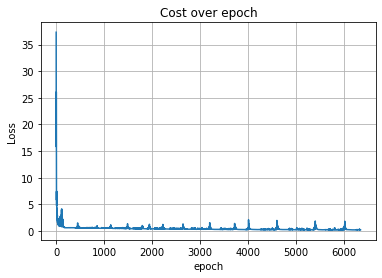

In [17]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.grid()
plt.show()

In [18]:
#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())
        
predictions = np.array(predictions, dtype=np.int8)

In [19]:
loan = np.where(predictions == 1)[0]
not_loan = np.where(predictions == 0)[0]
print(f"Prediction loans count: {len(loan)}")
print(f"Prediction not loans count: {len(not_loan)}")

Prediction loans count: 75
Prediction not loans count: 21


In [20]:
score = accuracy_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [21]:
print("Accuracy", score)
print("***Confusion Matrix stats***")
print(f"True Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive: {tp}")

Accuracy 0.71875
***Confusion Matrix stats***
True Negative: 11
False Positive: 17
False Negative: 10
True Positive: 58


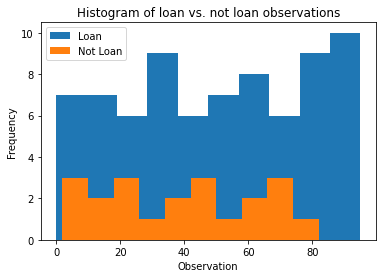

In [22]:
plt.hist(loan, label='Loan')
plt.hist(not_loan, label='Not Loan')
plt.legend()
plt.xlabel("Observation")
plt.ylabel("Frequency")
plt.title("Histogram of loan vs. not loan observations")
plt.show()

## Upload models

In [23]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../model/loans_model.pth")
### save tensors
torch.save([X_train, y_train], '../data/loans/tensor_train.pt')
torch.save([X_test, y_test],   '../data/loans/tensor_test.pt')